In [1]:
import numpy as np
import pandas as pd
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.externals import joblib
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

C:\Users\karthik.hegde\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [12]:
data = pd.read_csv('ratings_Electronics.csv',names=['user_id','product_id','rating','time_stamp'])

In [13]:
data.head()

,user_id,product_id,rating,time_stamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [15]:
data_final = data.drop(columns=['time_stamp'])

In [16]:
data_final.head()

,user_id,product_id,rating
0,AKM1MP6P0OYPR,0132793040,5.0
1,A2CX7LUOHB2NDG,0321732944,5.0
2,A2NWSAGRHCP8N5,0439886341,1.0
3,A2WNBOD3WNDNKT,0439886341,3.0
4,A1GI0U4ZRJA8WN,0439886341,1.0


In [17]:
#Check the number of rows and columns
rows,columns=data_final.shape
print('Number of rows: ',rows)
print('Number of columns: ',columns)

Number of rows:  7824482
Number of columns:  3


In [18]:
#Taking subset of the dataset
electronics_df1=data_final.iloc[:50000,0:]

In [21]:

#Summary statistics of rating variable
electronics_df1['rating'].describe().transpose()

count    50000.00000
mean         4.03524
std          1.35555
min          1.00000
25%          4.00000
50%          5.00000
75%          5.00000
max          5.00000
Name: rating, dtype: float64

In [23]:
print('Minimum rating is: %d' %(electronics_df1.rating.min()))
print('Maximum rating is: %d' %(electronics_df1.rating.max()))

Minimum rating is: 1
Maximum rating is: 5


### Distribution of Rating

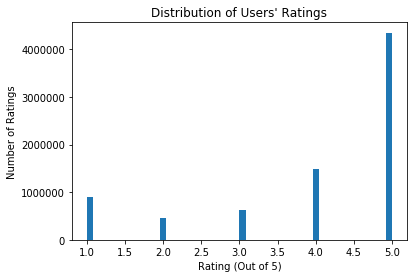

In [23]:
data.rating.plot.hist(bins=50)
plt.title("Distribution of Users' Ratings")
plt.ylabel('Number of Ratings')
plt.xlabel('Rating (Out of 5)');

### Remove all the users who has given less than 50 ratings

In [25]:
# df = data.groupby('user_id')['user_id'].count()
mask = data['user_id'].value_counts()

In [26]:
filtered = (data[data['user_id'].isin(mask[mask>50].index)]).reset_index(drop = True)

In [27]:
filtered.head()

,user_id,product_id,rating,time_stamp
0,AT09WGFUM934H,0594481813,3.0,1377907200
1,A32HSNCNPRUMTR,0970407998,1.0,1319673600
2,A17HMM1M7T9PJ1,0970407998,4.0,1281744000
3,A3CLWR1UUZT6TG,0972683275,5.0,1373587200
4,A3TAS1AG6FMBQW,0972683275,5.0,1353456000


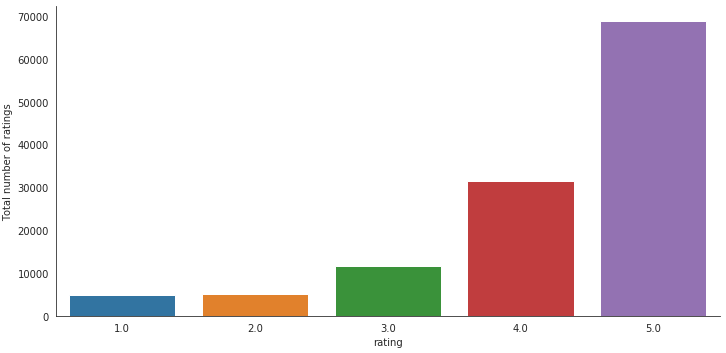

In [29]:
with sns.axes_style('white'):
    g = sns.factorplot("rating", data=filtered, aspect=2.0,kind='count')
    g.set_ylabels("Total number of ratings")

In [91]:
n_users = filtered['user_id'].unique().shape[0]
n_items =filtered['product_id'].unique().shape[0]
print("users:", n_users)
print("products:", n_items)

users: 1466
products: 47155


### Users and products

In [32]:
# Number of unique user id  in the data
print('Number of unique users in Raw data = ', filtered['user_id'].nunique())
# Number of unique product id  in the data
print('Number of unique product in Raw data = ', filtered['product_id'].nunique())

Number of unique users in Raw data =  1466
Number of unique product in Raw data =  47155


In [33]:
#constructing the pivot table
final_ratings_matrix = filtered.pivot(index = 'user_id', columns ='product_id', values = 'rating').fillna(0)
final_ratings_matrix.head()

product_id,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,1400599997,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
user_id,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
#Calucating the density of the rating marix
given_num_of_ratings = np.count_nonzero(final_ratings_matrix)
print('given_num_of_ratings = ', given_num_of_ratings)
possible_num_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1]
print('possible_num_of_ratings = ', possible_num_of_ratings)
density = (given_num_of_ratings/possible_num_of_ratings)
density *= 100
print ('density: {:4.2f}%'.format(density))

given_num_of_ratings =  122171
possible_num_of_ratings =  69129230
density: 0.18%


### Splitting the data

In [36]:
#Split the data randomnly into train and test datasets into 70:30 ratio
train_data, test_data = train_test_split(filtered, test_size = 0.3, random_state=0)
train_data.head()

,user_id,product_id,rating,time_stamp
24401,A1S7BFT0HDF3HA,B000TO1SMG,4.0,1281312000
83993,A1J75JJ0Q2OEJN,B0069QZ676,4.0,1375488000
33140,AGVWTYW0ULXHT,B001CHHVCU,3.0,1229040000
19305,ABXANRX4GPYRZ,B000IV413S,5.0,1212278400
108110,A1XE3M22N91451,B00BXA7N6A,5.0,1377302400


In [37]:

print('Shape of training data: ',train_data.shape)
print('Shape of testing data: ',test_data.shape)

Shape of training data:  (85519, 4)
Shape of testing data:  (36652, 4)


### Building Popularity Recommder model

In [40]:
#Count of user_id for each unique product as recommendation score 
train_data_grouped = train_data.groupby('product_id').agg({'user_id': 'count'}).reset_index()
train_data_grouped.rename(columns = {'user_id': 'score'},inplace=True)
train_data_grouped.head()

,product_id,score
0,0594481813,1
1,0970407998,2
2,0972683275,2
3,1400501466,3
4,1400501520,1


In [41]:
#Sort the products on recommendation score 
train_data_sort = train_data_grouped.sort_values(['score', 'product_id'], ascending = [0,1]) 
      
#Generate a recommendation rank based upon score 
train_data_sort['rank'] = train_data_sort['score'].rank(ascending=0, method='first') 
          
#Get the top 5 recommendations 
popularity_recommendations = train_data_sort.head(5) 
popularity_recommendations

,product_id,score,rank
30197,B0088CJT4U,150,1.0
19162,B003ES5ZUU,130,2.0
8448,B000N99BBC,112,3.0
29619,B007WTAJTO,104,4.0
29901,B00829TIEK,104,5.0


In [42]:
# Use popularity based recommender model to make predictions
def recommend(user_id):     
    user_recommendations = popularity_recommendations 
          
    #Add user_id column for which the recommendations are being generated 
    user_recommendations['userId'] = user_id 
      
    #Bring user_id column to the front 
    cols = user_recommendations.columns.tolist() 
    cols = cols[-1:] + cols[:-1] 
    user_recommendations = user_recommendations[cols] 
          
    return user_recommendations

In [43]:
find_recom = [10,100,150]   # This list is user choice.
for i in find_recom:
    print("The list of recommendations for the userId: %d\n" %(i))
    print(recommend(i))    
    print("\n")

The list of recommendations for the userId: 10

       userId  product_id  score  rank
30197      10  B0088CJT4U    150   1.0
19162      10  B003ES5ZUU    130   2.0
8448       10  B000N99BBC    112   3.0
29619      10  B007WTAJTO    104   4.0
29901      10  B00829TIEK    104   5.0


The list of recommendations for the userId: 100

       userId  product_id  score  rank
30197     100  B0088CJT4U    150   1.0
19162     100  B003ES5ZUU    130   2.0
8448      100  B000N99BBC    112   3.0
29619     100  B007WTAJTO    104   4.0
29901     100  B00829TIEK    104   5.0


The list of recommendations for the userId: 150

       userId  product_id  score  rank
30197     150  B0088CJT4U    150   1.0
19162     150  B003ES5ZUU    130   2.0
8448      150  B000N99BBC    112   3.0
29619     150  B007WTAJTO    104   4.0
29901     150  B00829TIEK    104   5.0




Since, it is a Popularity recommender model, so, all the three users are given the same recommendations. Here, we predict the products based on the popularity. It is not personalized to particular user. It is a non-personalized recommender system.

### Building Collaborative Filtering recommender model.

In [44]:
electronics_df_CF = pd.concat([train_data, test_data]).reset_index()
electronics_df_CF.head()

,index,user_id,product_id,rating,time_stamp
0,24401,A1S7BFT0HDF3HA,B000TO1SMG,4.0,1281312000
1,83993,A1J75JJ0Q2OEJN,B0069QZ676,4.0,1375488000
2,33140,AGVWTYW0ULXHT,B001CHHVCU,3.0,1229040000
3,19305,ABXANRX4GPYRZ,B000IV413S,5.0,1212278400
4,108110,A1XE3M22N91451,B00BXA7N6A,5.0,1377302400


### User Based Collaborative Filtering model

In [46]:
# Matrix with row per 'user' and column per 'item' 
pivot_df = electronics_df_CF.pivot(index = 'user_id', columns ='product_id', values = 'rating').fillna(0)
pivot_df.head()

product_id,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,1400599997,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
user_id,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
print('Shape of the pivot table: ', pivot_df.shape)

Shape of the pivot table:  (1466, 47155)


In [48]:
pivot_df['user_index'] = np.arange(0, pivot_df.shape[0], 1)
pivot_df.head()

product_id,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,1400599997,...,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8,user_index
user_id,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


In [49]:
pivot_df.set_index(['user_index'], inplace=True)
# Actual ratings given by users
pivot_df.head()

product_id,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,1400599997,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
user_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Singular Value Decomposition

In [53]:
# Singular Value Decomposition
U, sigma, Vt = svds(pivot_df, k = 10)

In [54]:
print('Left singular matrix: \n',U)

Left singular matrix: 
 [[-0.00960811  0.0047413  -0.01133839 ... -0.02155433 -0.03413016
  -0.02121137]
 [-0.01051152  0.01828392 -0.00440581 ... -0.01085919  0.02036194
  -0.03868162]
 [-0.00033812 -0.00410202 -0.00366842 ...  0.02975591  0.03284298
  -0.03354981]
 ...
 [-0.0059742   0.08701729  0.02149716 ... -0.01606818 -0.16121324
  -0.06013971]
 [ 0.00165383  0.00360442 -0.00378514 ... -0.00646961  0.00466412
  -0.01349047]
 [ 0.0006001   0.00414323  0.00198817 ... -0.01230474 -0.00229233
  -0.00561352]]


In [55]:

print('Sigma: \n',sigma)

Sigma: 
 [ 87.24957032  88.39685887  91.08547353  92.06057958  94.99760999
  98.0847158  100.33308601 106.66806285 119.47759792 181.5107964 ]


In [56]:
# Construct diagonal array in SVD
sigma = np.diag(sigma)
print('Diagonal matrix: \n',sigma)

Diagonal matrix: 
 [[ 87.24957032   0.           0.           0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.          88.39685887   0.           0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.           0.          91.08547353   0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.           0.           0.          92.06057958   0.
    0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.          94.99760999
    0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.
   98.0847158    0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.
    0.         100.33308601   0.           0.           0.        ]
 [  0.           0.           0.           0.           0.
    0.           0.      

In [57]:
print('Right singular matrix: \n',Vt)

Right singular matrix: 
 [[ 5.50536427e-04  1.07351822e-04  4.97209056e-03 ... -1.92240073e-02
  -8.30897610e-03 -1.60647481e-03]
 [-4.72716412e-04  4.11827301e-04 -3.93664027e-03 ... -2.75388338e-02
  -1.44923234e-03 -1.25127102e-03]
 [ 1.98409718e-04 -4.59856033e-04 -2.18098022e-03 ...  1.02843893e-02
   2.49122232e-03 -4.55604968e-04]
 ...
 [-1.31579189e-03 -4.67220584e-04 -6.77714820e-04 ...  1.33865670e-02
   4.39051485e-03 -1.17218739e-03]
 [-1.70856189e-04 -8.66485907e-05  5.47589425e-04 ... -3.34667526e-02
  -1.32027531e-02 -2.24109476e-03]
 [-2.58239126e-04 -6.66315892e-04 -2.29058738e-03 ... -1.04320457e-02
  -3.82718735e-03 -8.78261559e-04]]


In [58]:
#Predicted ratings
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 
# Convert predicted ratings to dataframe
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = pivot_df.columns)
preds_df.head()

product_id,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,1400599997,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
0,0.003574,0.004106,0.004114,0.001519,0.003071,0.005844,0.000504,0.010546,0.002704,0.000367,...,0.000605,0.044718,0.002920,0.060948,-0.002402,0.006796,0.001514,0.131030,0.059635,0.015090
1,0.002569,0.005363,0.013273,0.006607,0.001513,0.013490,0.000304,-0.004528,0.001254,0.011161,...,0.000228,0.029384,0.000089,0.000636,-0.003266,-0.000550,0.004386,-0.039361,-0.006408,0.003812
2,-0.002541,0.002095,0.017831,0.006890,-0.002171,0.005816,0.003470,-0.004045,-0.001645,0.010979,...,-0.000323,0.009498,-0.002494,-0.016874,0.019722,-0.002480,-0.000172,-0.003130,-0.011089,-0.004675
3,0.003963,0.001919,0.007592,0.002871,0.002890,0.003592,0.000112,0.005946,0.002477,0.000063,...,0.000616,-0.003098,0.003469,-0.003241,-0.000767,0.000159,0.002695,-0.015041,-0.007067,0.003539
4,0.000112,0.002091,0.008902,0.004068,0.000342,0.006062,0.001018,-0.000888,0.000375,0.006435,...,0.000007,-0.000698,-0.000316,-0.024802,0.004501,-0.002146,0.001284,-0.048613,-0.016151,-0.003332


In [59]:
# Recommend the items with the highest predicted ratings

def recommend_items(userID, pivot_df, preds_df, num_recommendations):
    # index starts at 0  
    user_idx = userID-1 
    # Get and sort the user's ratings
    sorted_user_ratings = pivot_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_ratings
    sorted_user_predictions = preds_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_predictions
    temp = pd.concat([sorted_user_ratings, sorted_user_predictions], axis=1)
    temp.index.name = 'Recommended Items'
    temp.columns = ['user_ratings', 'user_predictions']
    temp = temp.loc[temp.user_ratings == 0]   
    temp = temp.sort_values('user_predictions', ascending=False)
    print('\nBelow are the recommended items for user(user_id = {}):\n'.format(userID))
    print(temp.head(num_recommendations))

In [60]:
userID = 4
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 4):

                   user_ratings  user_predictions
Recommended Items                                
B007WTAJTO                  0.0          0.818424
B003ES5ZUU                  0.0          0.659610
B002V88HFE                  0.0          0.428778
B001TH7GUU                  0.0          0.387012
B000QUUFRW                  0.0          0.364006


### Evaluation of Collabrative recommendation model

In [50]:
# Actual ratings given by the users
final_ratings_matrix.head()

product_id,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,1400599997,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
user_id,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [51]:
final_ratings_matrix.mean().head()

product_id
0594481813    0.002046
0970407998    0.003411
0972683275    0.010232
1400501466    0.010232
1400501520    0.003411
dtype: float64

In [61]:
# Predicted ratings 
preds_df.head()

product_id,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,1400599997,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
0,0.003574,0.004106,0.004114,0.001519,0.003071,0.005844,0.000504,0.010546,0.002704,0.000367,...,0.000605,0.044718,0.002920,0.060948,-0.002402,0.006796,0.001514,0.131030,0.059635,0.015090
1,0.002569,0.005363,0.013273,0.006607,0.001513,0.013490,0.000304,-0.004528,0.001254,0.011161,...,0.000228,0.029384,0.000089,0.000636,-0.003266,-0.000550,0.004386,-0.039361,-0.006408,0.003812
2,-0.002541,0.002095,0.017831,0.006890,-0.002171,0.005816,0.003470,-0.004045,-0.001645,0.010979,...,-0.000323,0.009498,-0.002494,-0.016874,0.019722,-0.002480,-0.000172,-0.003130,-0.011089,-0.004675
3,0.003963,0.001919,0.007592,0.002871,0.002890,0.003592,0.000112,0.005946,0.002477,0.000063,...,0.000616,-0.003098,0.003469,-0.003241,-0.000767,0.000159,0.002695,-0.015041,-0.007067,0.003539
4,0.000112,0.002091,0.008902,0.004068,0.000342,0.006062,0.001018,-0.000888,0.000375,0.006435,...,0.000007,-0.000698,-0.000316,-0.024802,0.004501,-0.002146,0.001284,-0.048613,-0.016151,-0.003332


In [62]:
preds_df.mean().head()

product_id
0594481813    0.002380
0970407998    0.002716
0972683275    0.010664
1400501466    0.004101
1400501520    0.001564
dtype: float64

In [63]:
rmse_df = pd.concat([final_ratings_matrix.mean(), preds_df.mean()], axis=1)
rmse_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']
print(rmse_df.shape)
rmse_df['item_index'] = np.arange(0, rmse_df.shape[0], 1)
rmse_df.head()

(47155, 2)


,Avg_actual_ratings,Avg_predicted_ratings,item_index
product_id,,,
0594481813,0.002046,0.002380,0
0970407998,0.003411,0.002716,1
0972683275,0.010232,0.010664,2
1400501466,0.010232,0.004101,3
1400501520,0.003411,0.001564,4


In [64]:

RMSE = round((((rmse_df.Avg_actual_ratings - rmse_df.Avg_predicted_ratings) ** 2).mean() ** 0.5), 5)
print('\nRMSE SVD Model = {} \n'.format(RMSE))


RMSE SVD Model = 0.00342 



### Getting top - K ( K = 5) recommendations.

In [66]:
# Enter 'userID' and 'num_recommendations' for the user #
userID = 9
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 9):

                   user_ratings  user_predictions
Recommended Items                                
B004CLYEFK                  0.0          0.998857
B009NHWVIA                  0.0          0.986949
B007WTAJTO                  0.0          0.958857
B0088CJT4U                  0.0          0.928039
B0097CXWUW                  0.0          0.798786


The Popularity-based recommender system is a non-personalised recommender system and these are based on frequecy counts, which may be not suitable to the user.We can see the differance above for the user id 4, 6 & 8, The Popularity based model has recommended the same set of 5 products to both but Collaborative Filtering based model has recommended entire different list based on the user past purchase history.

Model-based Collaborative Filtering is a personalised recommender system, the recommendations are based on the past behavior of the user and it is not dependent on any additional information.